In [1]:
import sys
dir_repo = '../../'
sys.path.append(dir_repo)

from emu_Nx2pt.utils import get_config_from_yaml
from emu_Nx2pt.mlp_emulator import MLP_Emulator

! rm -rf /home/hhg/Research/emu_Nx2pt/repo/emulator_Nx2pt/experiments/mlp_test/

In [2]:
config = get_config_from_yaml(dir_repo+'configs/mlp_testATT.yaml')

emu = MLP_Emulator(config=config)


------ Parameters ------

exp_name : mlp_test
cuda : True
ngpu : 1
gpu_device : 0
workers : 16
dir_output : /home/hhg/Research/emu_Nx2pt/repo/emulator_Nx2pt/experiments
dir_dataT : {'train': '/home/hhg/Research/emu_Nx2pt/data/dataT_1M/', 'valid': '/home/hhg/Research/emu_Nx2pt/data/dataT_0.1M/'}
file_pco : {'train': '/home/hhg/Research/emu_Nx2pt/data/pco_1M.pkl', 'valid': '/home/hhg/Research/emu_Nx2pt/data/pco_0.1M.pkl'}
file_model_state : None
startID : 0
endID : 2425
model_type : AttentionBasedMLP
output_size : 2425
hidden_size : [256, 512]
encode_size : None
Nblocks : [2, 1]
scale_factor : 1
is_batchNorm : False
Nseq : 32
num_heads : 2
mlp_ratio : 2
dropout_p : 0.0
bias : False
num_epochs : 10
batch_size : 128
lr : 0.001
beta1 : 0.5
beta2 : 0.999
step_size : 10
gamma : 0.1
early_stop_threshold : 10
file_cov : /home/hhg/Research/emu_Nx2pt/data/cov3500.pkl
file_mask : /home/hhg/Research/emu_Nx2pt/data/10x2pt_RomanxSO_fid_mask.txt

------ Device ------

cuda:0

------ Prepare Data ----

In [3]:
emu.train()


------ Create experiment directory ------

Training information will be stored at :
 	 /home/hhg/Research/emu_Nx2pt/repo/emulator_Nx2pt/experiments/mlp_test
--- Epoch 1/10 ---
	train avg_chi2: 23601.74	valid avg_chi2: 3310.92	Time: 1m 9s
--- Epoch 2/10 ---
	train avg_chi2: 3567.51	valid avg_chi2: 2436.40	Time: 1m 10s
--- Epoch 3/10 ---
	train avg_chi2: 2719.30	valid avg_chi2: 1414.10	Time: 1m 13s
--- Epoch 4/10 ---
	train avg_chi2: 2250.79	valid avg_chi2: 1177.72	Time: 1m 15s
--- Epoch 5/10 ---
	train avg_chi2: 1904.97	valid avg_chi2: 795.07	Time: 1m 10s
--- Epoch 6/10 ---
	train avg_chi2: 1652.10	valid avg_chi2: 767.14	Time: 1m 13s
--- Epoch 7/10 ---
	train avg_chi2: 1484.49	valid avg_chi2: 514.82	Time: 1m 14s
--- Epoch 8/10 ---
	train avg_chi2: 1359.84	valid avg_chi2: 576.91	Time: 1m 14s
--- Epoch 9/10 ---
	train avg_chi2: 1240.25	valid avg_chi2: 709.30	Time: 1m 5s
--- Epoch 10/10 ---
	train avg_chi2: 1148.44	valid avg_chi2: 329.41	Time: 1m 16s

Minimum (epoch-averaged) validation l

## Plots: Training States

In [4]:
import numpy as np
import torch

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rc('font', size=16)

In [5]:
trainInfo = torch.load(emu.file_trainInfo)
trainInfo.keys()

dict_keys(['train_loss', 'valid_loss', 'epoch_train_loss', 'epoch_valid_loss', 'lr', 'best_epochID', 'best_model_wts'])

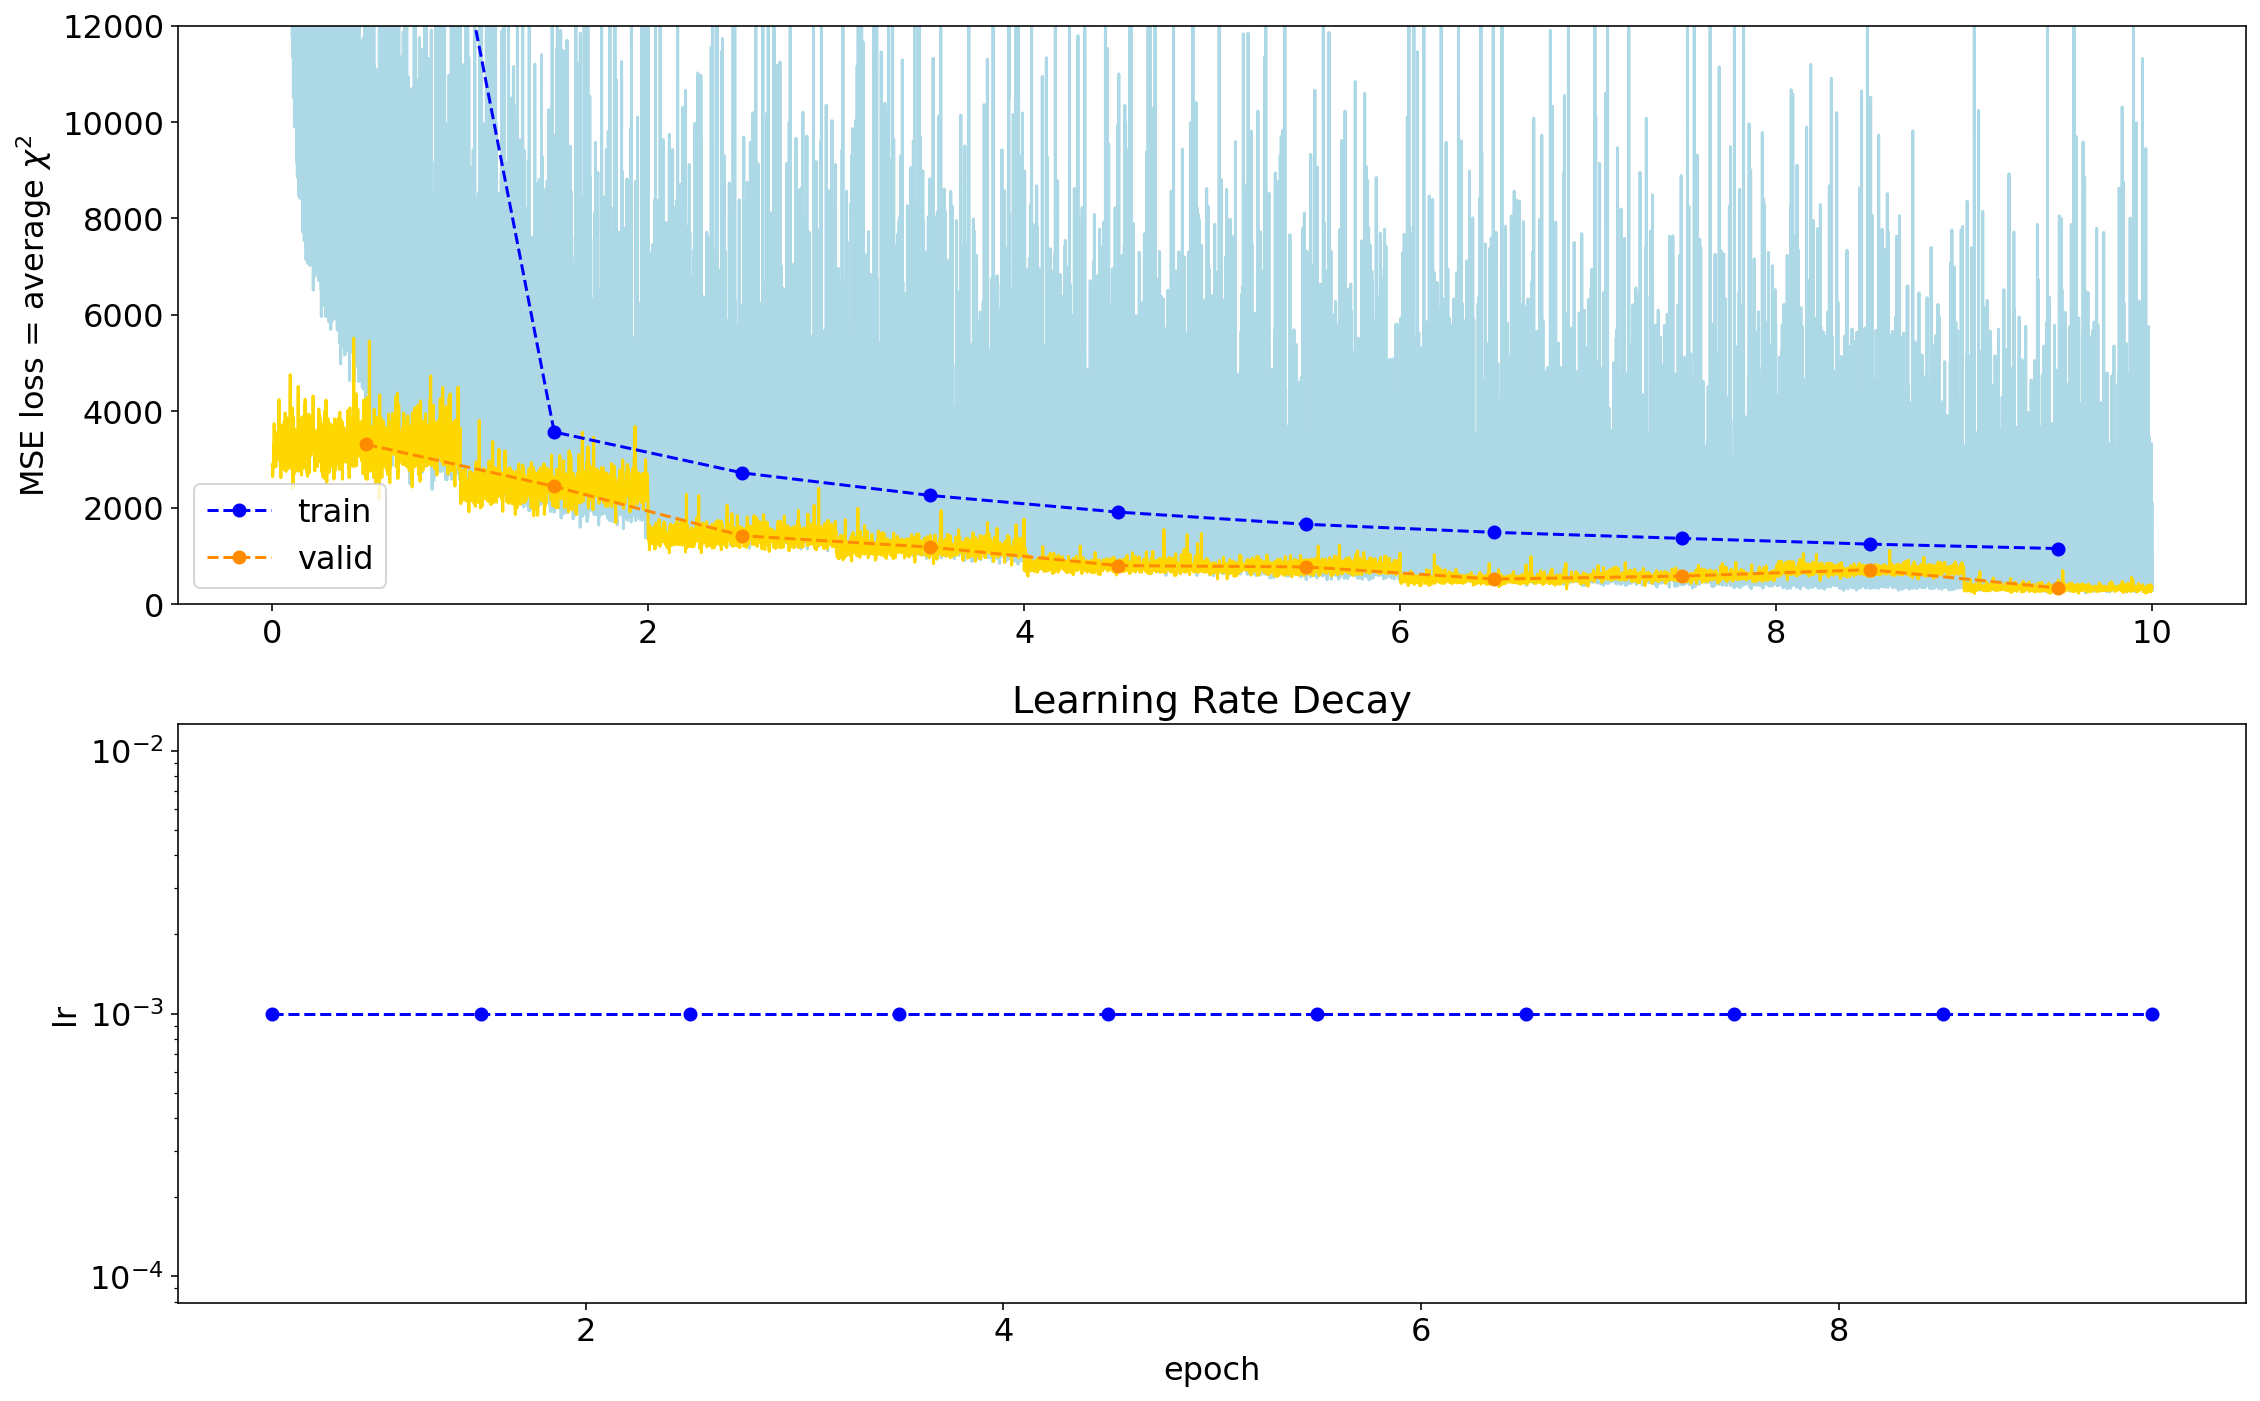

In [6]:
iter_tick = {}
for phase in ['train', 'valid']:
    iter_tick[phase] = np.array(range(len(trainInfo[f'{phase}_loss'])))/len(emu.dataloader[phase])

epoch_tick = np.array(range(len(trainInfo['epoch_train_loss'])))+0.5

# --------------------------

plt.figure(figsize=(16,10))

plt.subplot(211)

n = 1
plt.plot(iter_tick['train'][::n], trainInfo['train_loss'][::n], color='lightblue')
plt.plot(iter_tick['valid'][::n], trainInfo['valid_loss'][::n], color='gold')

plt.plot(epoch_tick, trainInfo['epoch_train_loss'], 'o--', label='train', color='b')
plt.plot(epoch_tick, trainInfo['epoch_valid_loss'], 'o--', label='valid', color='darkorange')

plt.ylabel('MSE loss = average $\chi^2$')

plt.legend()

#plt.xlim([10,20])
plt.ylim([0,12000])


plt.subplot(212)
plt.plot(epoch_tick, trainInfo['lr'], 'o--', label='train', color='b' )
plt.title('Learning Rate Decay')
plt.ylabel('lr')
plt.yscale('log')
plt.xlabel('epoch')


plt.tight_layout()

## Check the Performance of the Best Trained Emulator

In [7]:
import torch
import pandas as pd
import pickle
from emu_Nx2pt.data_kits import dataTDataset
from torch.utils.data import DataLoader

In [8]:
filename_pco = '/home/hhg/Research/emu_Nx2pt/data/pco_0.1M.pkl'
dir_dataT = '/home/hhg/Research/emu_Nx2pt/data/dataT_0.1M/'

with open(filename_pco, 'rb') as handle:
    pco_samples = pickle.load(handle)

test_pco = pd.DataFrame(pco_samples)

test_dataset = dataTDataset(test_pco, dir_dataT, emu.startID, emu.endID)
dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=16)

In [9]:
avg_test_chi2 = emu.test(dataloader)
avg_test_chi2

Test model with the best-trained model at epochID: 9

------ Run test loop ------

  Number of galaxies: 100000 (196 batches)
  Average chi2 of the test set: 329.41


329.40913875

### Visualize emulated dataV

In [10]:
trainInfo = torch.load(emu.file_trainInfo)
emu.model.load_state_dict(trainInfo['best_model_wts'])

# ---------------------------------------------------------------------------

# stateID = 7
# stateInfo = torch.load(emu.dir_checkpoints + f'/stateInfo_{stateID}.pth')
# emu.model.load_state_dict(stateInfo['model_state_dict'])

<All keys matched successfully>

In [11]:
pcoID, pco, dataT = test_dataset[0]
pco = pco.to(emu.device)
pco

tensor([ 0.3075,  0.8121,  0.9090, -1.0232,  0.9379,  0.0462,  0.5947,  0.5372,
         0.4307,  1.1756,  0.5976, 13.8068,  1.3331,  6.6117,  0.7558, -0.2047,
        -0.1601], device='cuda:0')

In [12]:
dataV_true = emu.L@dataT.numpy()
dataV_emu  = emu.gen_dataV(pco)

dataT_true = dataT.to('cpu').numpy()
dataT_emu  = emu.gen_dataT(pco)
chi2 = np.sum((dataT_true-dataT_emu)**2)

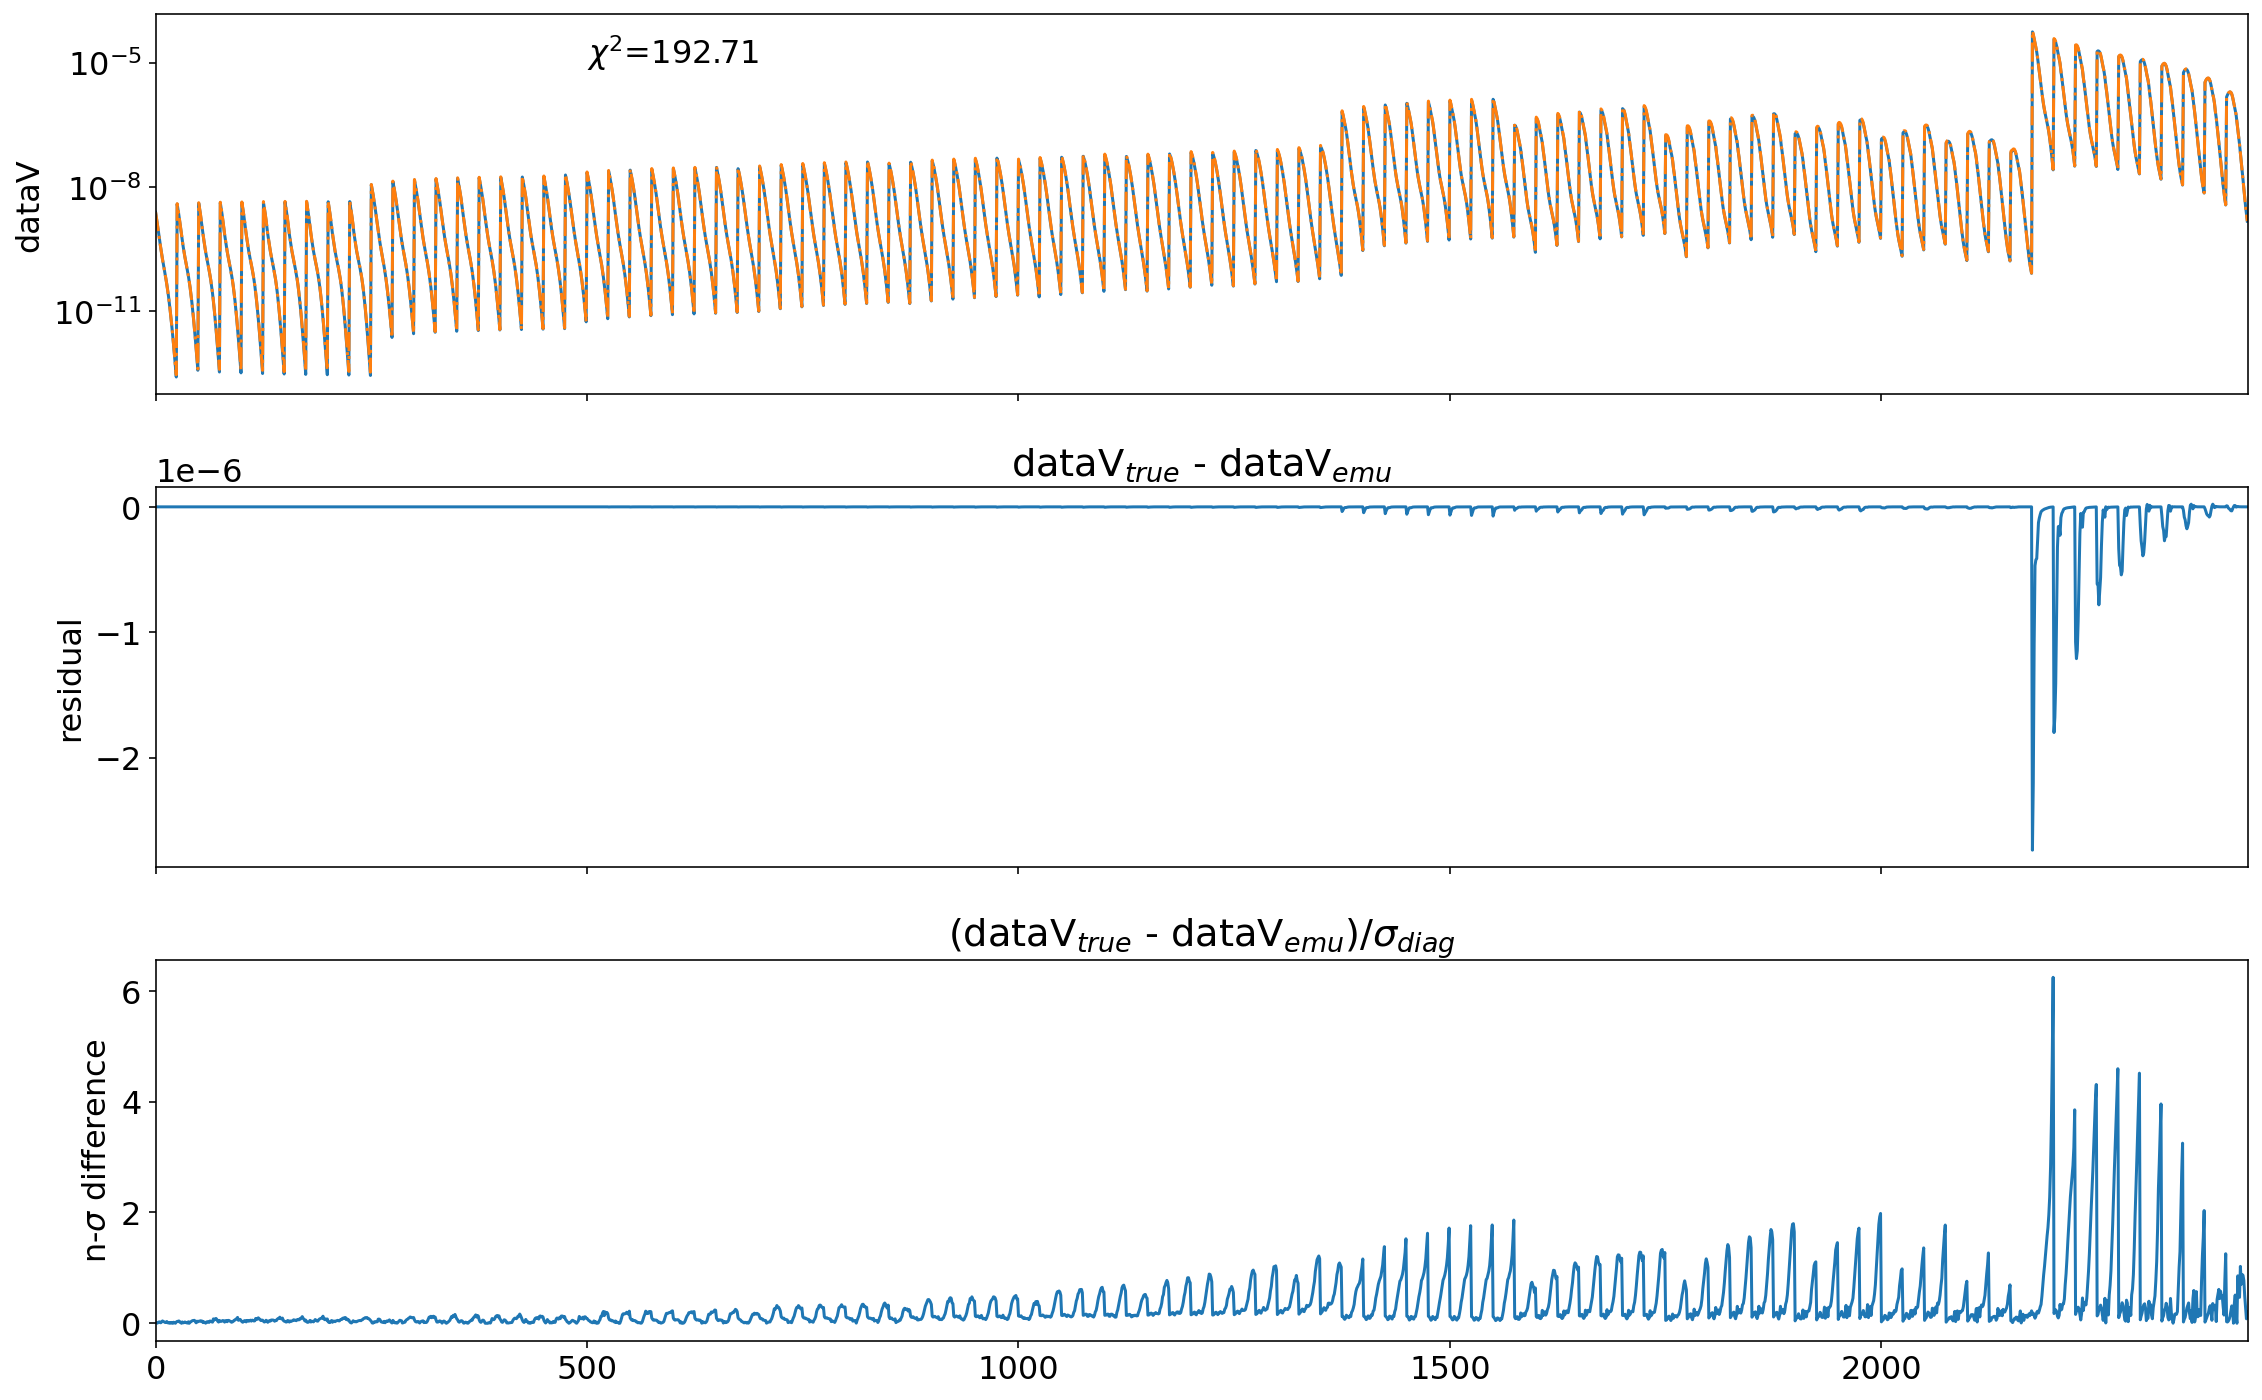

In [13]:
plt.figure(figsize=(16,10))
plt.subplots_adjust(hspace=0.01)

plt.subplot(311)
plt.plot(range(0,emu.endID), dataV_true)
plt.plot(range(0,emu.endID), dataV_emu, ls='-.')
plt.text(500, 1e-5, f"$\chi^2$={chi2:.2f}")

plt.yscale('log')
plt.ylabel('dataV')
plt.xlim([0, emu.endID])
_ = plt.xticks(range(0,emu.endID, 500),[])

plt.subplot(312)
plt.plot(range(0,emu.endID), dataV_true-dataV_emu)
plt.ylabel('residual')
plt.title('dataV$_{true}$ - dataV$_{emu}$')
_ = plt.xticks(range(0,emu.endID, 500),[])
plt.xlim([0, emu.endID])


plt.subplot(313)
dataV_diag_std = np.sqrt(emu.cov_masked.diagonal())[0:emu.endID]
plt.plot(range(0,emu.endID), abs(dataV_true-dataV_emu)/dataV_diag_std )
plt.title('(dataV$_{true}$ - dataV$_{emu}$)/$\sigma_{diag}$')
plt.ylabel('n-$\sigma$ difference')
plt.xlim([0, emu.endID])


plt.tight_layout()